# AE Experimentation

## Imports and Constants

In [3]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import ConvAE1, ConvAE2, train_autoencoder

In [5]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

In [6]:
model_name = "ConvAE2"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 1000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [7]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_df.shape

(28511, 5)

In [8]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [9]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [10]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [11]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [12]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [13]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [14]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [ ]:
if model_name == "ConvAE1":
    model = ConvAE1(verbose=False).to(hyperparameters['device'])
elif model_name == "ConvAE2":
    model = ConvAE2(verbose=True).to(hyperparameters['device'])

In [18]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

In [20]:
model_path = f"{model_name}_checkpoint.pth"

train_autoencoder(
    model=model,
    hyperparameters=hyperparameters,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    save_path=model_path
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
I

  0%|          | 0/1000 [00:02<?, ?it/s]

Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
Input after unsqueeze and permute: torch.Size([32, 5, 12])
After conv1: torch.Size([32, 5, 6])
After conv2: torch.Size([32, 5, 4])
After conv3: torch.Size([32, 5, 1])
After conv_tran1: torch.Size([32, 5, 4])
After conv_tran2: torch.Size([32, 5, 6])
After conv_tran3: torch.Size([32, 5, 12])
After re-permute: torch.Size([32, 12, 5])
I

KeyboardInterrupt: 

In [ ]:
if model_name == "ConvAE1":
    test_model = ConvAE1(verbose=False).to(hyperparameters['device'])
elif model_name == "ConvAE2":
    test_model = ConvAE2(verbose=True).to(hyperparameters['device'])

test_model.load_state_dict(torch.load(model_path))

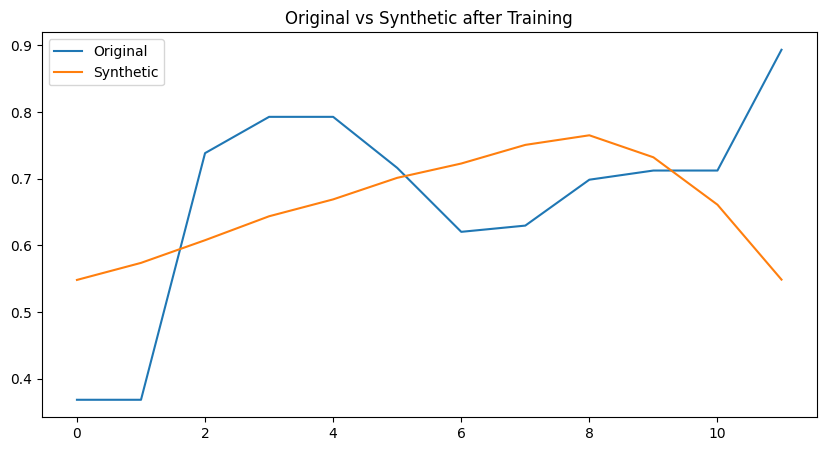

In [ ]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [ ]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [ ]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([22797, 12, 5]),
 torch.Size([2840, 12, 5]),
 torch.Size([2841, 12, 5]))

In [ ]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [ ]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [ ]:
result.shape

(28478, 12, 5)

In [ ]:
no, seq, dim = result.shape
result = result.reshape(no, seq*dim)

In [ ]:
# np.savetxt(f'mitv_{28478}_{12}_{5}_autoencoder.csv', result, delimiter=',')